# Recurrent Neural Networks

Recurrent neural network is a type of network architecture that accepts variable inputs and variable outputs, which contrasts with the vanilla feed-forward neural networks. 

We can also consider input with variable length, such as video frames and we want to make a decision along every frame of that video.

## Process Sequences
![sequence](img/sequence.png)

#### one to one
This is the classic feed forward neural network architecture, with one input and we expect one output.

#### one to many
This can be thought of as image captioning. We have one image as a fixed size input and the output can be words or sentences which are variable in length.

#### many to one
This is used for sentiment classification. The input is expected to be a sequence of words or even paragraphs of words. The output can be a regression output with continuous values which represent the likelihood of having a positive sentiment.

#### many to many
This model is ideal for machine translation like the one we see on Google translate. The input could an English sentence which has variable length and the output will be the same sentence in a different language which also has variable length. 

The last many to many model can be used for video classification on frame level. Feed every frame of a video into the neural network and expect an output right away. However, since frames are generally dependent on each other, it is necessary for the network to propagate its hidden state from the previous to the next. Thus, we need recurrent neural network for this kind of task.

## Mathematical Formulation
We can process a sequence of vectors **x** applying a recurrence formula at every time step:

$$
h_{t} = f_{W}(h_{t - 1}, x_{t})
$$

`x[t]` is input vector at some time step while `h[t - 1]` is the previous hidden state and `h[t]` is the new hidden state produced by the network. The whole forward propagation can be characterized by the function of **W**.

**NOTE**: The same function and same set of parameters are used at every time step.

### Example
Here's a simple vanilla recurrent neural network example in functional form. Notice that if we were to produce `h[t]`, we need some weight matrices, `h[t-1]`, `x[t]` and a non-linearity `tanh`.

$$
h_{t} = tanh(W_{hh}h_{t-1} + W_{xh}x_{t})
$$

If we want to produce an output at every timestep, then we want another weight matrix that accepts a hidden state and project it to an output `y`

$$
y_{t} = W_{hy}h_{t}
$$

In [1]:
import numpy as np


np.random.seed(0)
class RecurrentNet(object):
    """When we say W_hh, it means a weight matrix that accepts a hidden state and produce a new hidden state. 
    Similarly, W_xh represents a weight matrix that accepts an input vector and produce a new hidden state.
    """
    def __init__(self):
        self.hidden_state = np.zeros((3, 3))
        self.W_hh = np.random.randn(3, 3)
        self.W_xh = np.random.randn(3, 3)
        self.W_hy = np.random.randn(3, 3)
    
    def forward_prop(self, x):
        self.hidden_state = np.tanh(self.W_hh.dot(self.hidden_state) + self.W_xh.dot(x))
        
        return self.W_hy.dot(self.hidden_state)

In [2]:
input_vector = np.ones((3, 3))
silly_network = RecurrentNet()

# Notice that same input, but leads to different ouptut at every single time step.
print silly_network.forward_prop(input_vector)
print silly_network.forward_prop(input_vector)
print silly_network.forward_prop(input_vector)

[[-2.80121891 -2.80121891 -2.80121891]
 [ 0.69469708  0.69469708  0.69469708]
 [ 0.96886448  0.96886448  0.96886448]]
[[-3.04406657 -3.04406657 -3.04406657]
 [ 0.7898616   0.7898616   0.7898616 ]
 [ 0.86068273  0.86068273  0.86068273]]
[[-3.04498651 -3.04498651 -3.04498651]
 [ 0.78981591  0.78981591  0.78981591]
 [ 0.86049092  0.86049092  0.86049092]]


## Computational Graph
Instead of imagining that hidden state is being *recurrently* fed back into the network, it's easier to visualize the process if we unroll the operation into a computational graph that is composed to many time steps.

For example, we begin with a zero'ed vector as our hidden state on the left. We feed it into the network along with our first input. When we receive the next input, we take the new hidden state and feed it into the network again with the second input. The procoess goes on until the point we wish to compute the final output of the network.

![computational-graph-1](img/computational-graph-1.png)

We use the same set of weight for every time step of the computation.

![computational-graph-2](img/computational-graph-2.png)

### Computational Graph - Many to Many
For the many-to-many case, we compute a `y[t]` and the loss for every time step. At the end we simply sum up the loss of all the time steps and count that as our total loss of the network. 

When we think about the back propagation for this model, we will have a separate gradient for W flowing from each of those time steps and then the final gradient for W will be the sum of all those individual time step gradients. *Imagine that we have some sort of ground-truth label for every step of the sequence*:


![computational-graph-many-to-many](img/computational-graph-many-to-many.png)



### Computational Graph - Many to One
If we have this many to one situation, we make the decision based on the final hidden state of this network. This final hidden state summarizes all of the context from the entire sequence. 


![computational-graph-many-to-one](img/computational-graph-many-to-one.png)

### Computational Graph - One to Many
If we have this one to many situation, where we want to receive a fixed size input and produce a variable length output, then you would commonly use that fixed size input to initialize the hidden state and then let the network to propagate and evolve the hidden state forward. 


![computational-graph-one-to-many](img/computational-graph-one-to-many.png)

## Squence to Sequence
For the sequence to sequence models where you might want to do something like machine translation, this is a combination of **many-to-one** and **one-to-many** architecture. We proceed in two stages, (1) the encoder receives a variably sized input like an english sentence and performs encoding into a hidden state vector, (2) the decoder receives the hidden state vector and produces a variably sized output. The motivation of using this architecture is modularity. We can easily swap out encoder and decoder for different type of language translation.

## Character-leve Languag Model
### Training Time
Suppose that we have a character-level language model, the list of possible *vocabularies* is `['h', 'e', 'l', 'o']`.  An example training sequence is `hello`. The same output from hidden layer is being fed to output layer and the next hidden layer, as noted below that `y[t]` is a product of `W_hy` and `h[t]`. Since we know what we are expecting, we can backpropagate the cost and update weights.

The `y[t]` is a prediction for which letter is most likely to come next. For example, when we feed `h` into the network, `e` is the expected output of the network because the only training example we have is `hello`. 

![language-model](img/language-model.png)

### Test Time
At test time, we sample characters one at a time and feed it back to the model to produce a whole sequence of characters (which makes up a word.) We seed the word with a prefix like the letter **h** in this case. The output is a softmax vector which represents probability. We can use it as a probability distribution and perform sampling.

**This means EACH character has some chance to be selected** Samplng technique gives us more diversity in the output. This is evident in sentence construction. Given a prefix, we can have multiple words and phrases to represent the same idea.

![language-model-test-time](img/language-model-test-time.png)

## Backpropagation
The concept of backpropagation through time is that we forward through entire sequence to compute loss, then backward through entire sequence to compute gradient. However, this becomes problematic when we want to train a sequence that is very long. For example, if we were to train a a paragraph of words, we have to iterate through many layers before we can compute one simple gradient step.

### Truncated Backprop
In practice, what people do is an approximation called truncated backpropagation through time. Run forward and backward through chunks of the sequence instead of the whole sequence. Even though our input sequence can potentially be very long or even infinite, when we are training our model, we will step forward for some number of steps and compute a loss only over this sub sequence of the data. Then backpropagate through this sub-sequence and make a gradient step on the weights. 

When we move to the next batch, we still have this hidden state from the previous batch of data, we will carry this hidden state forward. The forward pass is unaffected but we will only backpropgate again through this second batch. 

![truncated-backprop](img/truncated-backprop.png)

###  Example: Minimal character-level Vanilla RNN model
Let's use the same `tanh` example we had up there to implement a single layer recurrent nerual network. The forward pass is quite easy. Assuming the input is a list of character index, i.e. `a => 0`, `b => 1`, etc..., the target is a list of character index that represents the next letter in the sequence. For example, the target is characters of the word `ensorflow` and the input is `tensorflo`. Given a letter `t`, it should predict that next letter is `e`. 

```python
# Encode input state in 1-of-k representation
input_states[t] = np.zeros((self.input_dim, 1))
input_states[t][input_list[t]] = 1

# Compute hidden state
hidden_states[t] = tanh(dot(self.params['Wxh'], input_states[t]) +
                        dot(self.params['Whh'], hidden_states[t-1]) +
                        self.params['Bh'])

# Compute output state a.k.a. unnomralized log probability using current hidden state
output_states[t] = dot(self.params['Why'], hidden_states[t]) + self.params['By']

# Compute softmax probability state using the output state
prob_states[t] = exp(output_states[t]) / np.sum(exp(output_states[t]))
```

Now here's the fun part, computing the gradients for backpropagation. First of all, let's remind ourself what our model is.


$$
h_{t} = tanh(W_{hh}h_{t-1} + W_{xh}x_{t}) + B_{h}
$$

$$
y_{t} = W_{hy}h_{t} + B_{y}
$$

First compute the gradient of loss with respect to output vector `y`:

$$
\frac{\partial L}{\partial y_{t}}
$$

```python
# Softmax gradient
grad_output = np.copy(prob_states[t])
grad_output[target_list[t]] -= 1
```

Then gradient of loss with respect to `Why`, `h`, and the bias:

$$
\frac{\partial L}{\partial W_{hy}} = \frac{\partial L}{\partial y_{t}} \cdot \frac{\partial y_{t}}{\partial W_{hy}}
$$

$$
\frac{\partial L}{\partial B_{y}} = \frac{\partial L}{\partial y_{t}} \cdot \frac{\partial y_{t}}{\partial B_{y}}
$$

$$
\frac{\partial L}{\partial h_{t}} = \frac{\partial L}{\partial y_{t}} \cdot \frac{\partial y_{t}}{\partial h_{t}}
$$

```python
grads['Why'] += dot(grad_output, hidden_states[t].T)
grads['By'] += grad_output
grad_h = dot(self.params['Why'].T, grad_output) + grad_prev_h # (H, O)(O, H) => (H, H)
```

We need to perform a little u-substitution here to simplify our derivatives. 

$$
h_{t} = tanh(u) + B_{h}
$$

So we find the gradient of loss with respect to `u` and then use that to find rest of the gradients. 

$$
\frac{\partial L}{\partial u} = \frac{\partial L}{\partial h_{t}} \cdot \frac{\partial h_{t}}{\partial u}
$$

$$
\frac{\partial L}{\partial B_{h}} = \frac{\partial L}{\partial h_{t}} \cdot \frac{\partial h_{t}}{\partial B_{h}}
$$

```python
grad_u = (1 - hidden_states[t] * hidden_states[t]) * grad_h
grads['Bh'] += grad_u
```

Finally, we can compute the gradients for the last two parameters:

$$
\frac{\partial L}{\partial W_{xh}} = \frac{\partial L}{\partial u} \cdot \frac{\partial u}{\partial W_{xh}}
$$

$$ 
\frac{\partial L}{\partial W_{hh}} = \frac{\partial L}{\partial u} \cdot \frac{\partial u}{\partial W_{hh}}
$$

$$
\frac{\partial L}{\partial h_{t-1}} = \frac{\partial L}{\partial u} \cdot \frac{\partial u}{\partial h_{t-1}}
$$

```python
grads['Wxh'] += dot(grad_u, input_states[t].T)
grads['Whh'] += dot(grad_u, hidden_states[t-1].T)
grad_prev_h = dot(self.params['Whh'].T, grad_u)
```

In [3]:
import numpy as np
from adagrad import AdaGradOptimizer
from data_util import *
from vanilla_rnn import VanillaRNNModel

hidden_dim = 100
seq_length = 50
learning_rate = 1e-1
text_data, char_to_idx, idx_to_char = load_dictionary("datasets/word_dictionary.txt")
model = VanillaRNNModel(len(char_to_idx), hidden_dim)
optimizer = AdaGradOptimizer(model, learning_rate)

text document contains 727 characters and has 40 unique characters


In [4]:
curr_iter, pointer, epoch_size, total_iters = 0, 0, 100, 20000

steps, losses = [], []
while curr_iter < total_iters:
    if curr_iter == 0 or pointer + seq_length + 1 >= len(text_data):
        prev_hidden_state = np.zeros((hidden_dim, 1))  # Reset RNN memory
        pointer = 0  # Reset the pointer
    
    # Since we are trying to predict next letter in the sequence, the target is simply pointer + 1
    input_list = [char_to_idx[ch] for ch in text_data[pointer:pointer+seq_length]]
    target_list = [char_to_idx[ch] for ch in text_data[pointer+1: pointer+seq_length+1]]
    loss, grads, prev_hidden_state = model.loss(input_list, target_list, prev_hidden_state)
    if curr_iter % epoch_size == 0:
        steps.append(curr_iter)
        losses.append(loss)
        
    optimizer.update_param(grads)
    curr_iter += 1 
    pointer += seq_length

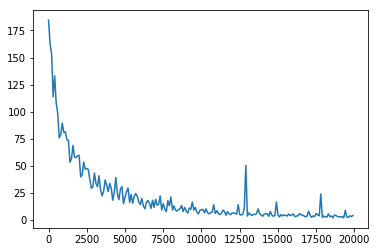

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.plot(steps, losses)
plt.show()

In [6]:
# Pick a random character and sample a 100 characters long sequence (i.e. a sentence.)
letter = 'H'
hidden_state = np.zeros_like((hidden_dim, 1))
_, sampled_indices = model.sample_chars(prev_hidden_state, char_to_idx[letter], 1000)
predicted_text = ''.join(idx_to_char[idx] for idx in sampled_indices)
print "-------------\n%s\n-------------" % predicted_text

-------------

Harow y,
I doubted if I thy
I sng ales fir wig hand woodt pavel caat the pa thad wook.
I toubass her way lelding the ing paver come back.
I shablent I coow wim,
And ood wook ther, agep helllabloth hen trok the per dias just as fair,
And having pack.
Oh, I kept the passingwthads far as I could
Tn the und rorged weand I-
I took the one lesselodhi;
Theter, lent ond bot tellae that as aod
Thoudaigh
 ood yyinghlorhen black.
Oh, I kept the first f or,
And both them roallars waI st the utrasther clally In took the other, agel asarn tooked hasthads oo that tr woodelecergrl thad wir;
The waes I coued and I could not travel both
And be one traveler, long I stood
And looked down one as far as I cook the same,
And by louthe on that the undimgwleiescergrl Iesthererowth;
Then togn to wing there in w wood, and I-
I took the one lesseloksss rn to,
And that hasse
Had wor sngn the passing hand that tre und ine ped ages hen tey and tod,
And both thelethergvlotdiAgvene anit  ver wlock.
Thou